In [1]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load ViT-B/32 CLIP model
model_vit, preprocess_vit = clip.load("ViT-B/32", device=device)

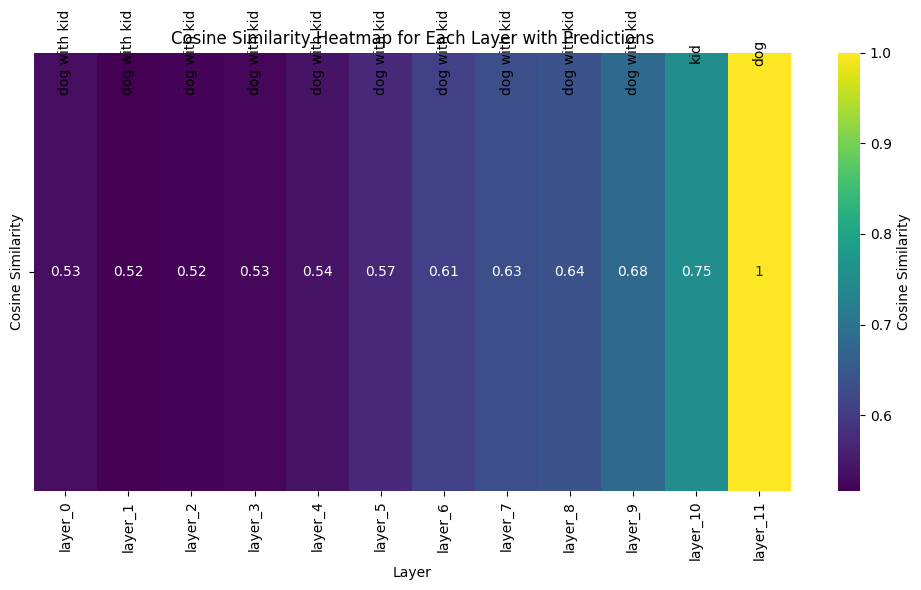

In [ ]:
import torch
import torch.nn.functional as F
import clip
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from types import MethodType

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP ViT model
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

# Load and preprocess image
image_path = "dog_with_kid.jpg"
image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

# Tokenize text prompts
text = clip.tokenize(["a photo of a cat","dog","dog with kid", "kid", "bird"]).to(device)

# === Step 1: Wrap transformer blocks to capture CLS tokens ===
def wrap_vit_blocks(model):
    original_blocks = model.visual.transformer.resblocks
    activations = {}

    for i, block in enumerate(original_blocks):
        def make_custom_forward(orig_block, layer_name):
            def custom_forward(self, x):
                out = orig_block(x)
                activations[layer_name] = out.clone()
                return out
            return custom_forward

        block.forward = MethodType(make_custom_forward(block.forward, f"layer_{i}"), block)

    return activations

activations = wrap_vit_blocks(model)

# === Step 2: Run forward pass ===
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

# Normalize final image features
final_output = F.normalize(image_features, dim=-1)

# === Step 3: Logit lens analysis with predictions ===
def logit_lens_analysis(activations, projection_head, ln_post, final_output, text_features):
    distances = {}
    predictions = {}
    for name, x in activations.items():
        # x shape: (seq_len, batch, dim)
        x = x.permute(1, 0, 2)  # -> (batch, seq_len, dim)
        cls_token = x[:, 0, :]  # take CLS token

        # Apply final layer norm
        cls_token = ln_post(cls_token)

        # Project using CLIP's final projection matrix
        projected = cls_token @ projection_head  # (1, 512)
        projected = F.normalize(projected, dim=-1)

        # Cosine similarity with final output
        similarity = F.cosine_similarity(projected, final_output, dim=-1)
        distances[name] = similarity.item()

        # Find the predicted text by computing cosine similarity with text features
        text_similarity = F.cosine_similarity(projected, text_features, dim=-1) 
        predicted_idx = torch.argmax(text_similarity).item()
        predictions[name] = ["a photo of a cat", "kid","dog","dog with kid", "bird"][predicted_idx]

    return distances, predictions

# Run analysis
distances, predictions = logit_lens_analysis(activations, model.visual.proj, model.visual.ln_post, final_output, text_features)

# === Step 4: Plot results as a heatmap ===
# Prepare data for heatmap
layer_names = sorted(distances.keys(), key=lambda x: int(x.split('_')[1]))
similarity_values = [distances[layer] for layer in layer_names]
predicted_labels = [predictions[layer] for layer in layer_names]

# Create a heatmap plot
plt.figure(figsize=(10, 6))
sns.heatmap(np.array(similarity_values).reshape(1, -1), annot=True, cmap="viridis", xticklabels=layer_names, yticklabels=["Cosine Similarity"], cbar_kws={'label': 'Cosine Similarity'}, cbar=True)

# Add text labels for predictions
for i, label in enumerate(predicted_labels):
    plt.text(i + 0.5, 0, label, ha='center', va='center', color='black', fontsize=10, rotation=90)

plt.title("Cosine Similarity Heatmap for Each Layer with Predictions")
plt.xlabel("Layer")
plt.tight_layout()
plt.show()
